# Use GANs to create art - will you be the next Monet?

github: https://github.com/zpeople/Monet_cycleGAN

[12/18/2024 Wed 10:21:36] BY Renmin Zhao

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



from tensorflow.keras import layers ,Model
from tensorflow.keras.layers import Dense, Flatten,Reshape,BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



In [68]:
tf.__version__

'2.16.1'

In [69]:

try:
  
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:  
    print("No TPU found, using default strategy.")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy()
            print("Using MirroredStrategy for GPU distribution.")
        except RuntimeError as e:
            print(e)
    else:
        strategy = tf.distribute.get_strategy()
        print("No GPU found, using default strategy.")

print('Number of replicas:', strategy.num_replicas_in_sync)



No TPU found, using default strategy.
No GPU found, using default strategy.
Number of replicas: 1


TFRecord is a binary file format used by TensorFlow for efficient storage of large data sets. Instead of storing data directly in a human-readable format, it serializes the data into a compact, continuous format, which makes TFRecord files ideal for use in input pipelines, especially when large data sets need to be processed.

A TFRecord file consists of a series of records, each of which is a string, with the following internal structure:

Length Prefix: A VARint-encoded integer indicating the byte length of the next part of the data.
Data: Actual data, which can be any byte stream.
CRC-32C Checksum (CRC-32C Checksum) : Another Varint-encoded integer containing the CRC-32C checksum, used to verify that parts of the data were corrupted during transmission or storage.

### Load Data
The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [70]:

# Defining the directories for the image locations
LOAD_LOCALMODEL= True
INPUT_PATH='Datasets'
OUT_PUT_PATH ='./'


# INPUT_PATH='/kaggle/input/gan-getting-started'
# OUT_PUT_PATH ='/kaggle/working/'

monet_jpegs = INPUT_PATH+"/monet_jpg"
photos_jpegs = INPUT_PATH+"/photo_jpg"
monet_tfrec = INPUT_PATH+"/monet_tfrec"
photos_tfrec = INPUT_PATH+"/photo_tfrec"
MONET_FILENAMES = tf.io.gfile.glob(str(monet_tfrec+'/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(photos_tfrec + '/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Load TFRecord to Image

In [71]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 2
EPOCHS =25
def tfrec2image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tfrec2image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


monet_data = load_dataset(MONET_FILENAMES)
photo_data = load_dataset(PHOTO_FILENAMES)


Augment data


In [72]:
with strategy.scope():
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738
# from https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py



    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x


    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x


    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x


    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
}
    def aug_fn(image):
        return DiffAugment(image,"color")

In [73]:
with strategy.scope():
    monet_data = monet_data.repeat()
    photo_data = photo_data.repeat()
        
    # monet_data = monet_data.shuffle(2048)
    # photo_data = photo_data.shuffle(2048)

    def flip(image):
        return tf.image.random_flip_left_right(image)

    monet_data = monet_data.map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
    photo_data = photo_data.map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)

    monet_data = monet_data.map(flip, num_parallel_calls=tf.data.AUTOTUNE)
    photo_data = photo_data.map(flip, num_parallel_calls=tf.data.AUTOTUNE)


In [74]:
for batch_monet_images in monet_data.take(1):  
    print("Shape of a batch of images:", batch_monet_images.shape)
for batch_photo_images in photo_data.take(1):  
    print("Shape of a batch of images:", batch_photo_images.shape)

Shape of a batch of images: (2, 256, 256, 3)
Shape of a batch of images: (2, 256, 256, 3)


View Photo and Monet image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02750194..1.253878].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21442956..0.7581303].


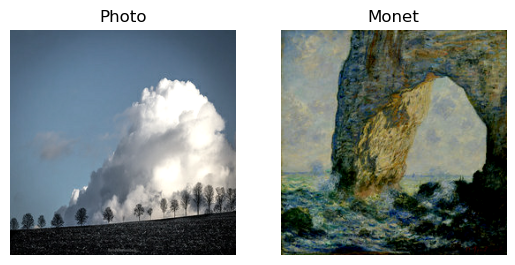

In [75]:
plt.subplot(1,2,1)
plt.title('Photo')
plt.imshow(batch_photo_images[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(batch_monet_images[0] * 0.5 + 0.5)
plt.axis('off')

plt.show()

In [76]:

class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer="ones",
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.scale * (inputs - mean) / tf.sqrt(variance + self.epsilon) + self.offset

# filter-The number of filters in the Conv2D layer is the number of output feature maps
# size -Convolution kernel size
def Cov2d(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        instance_norm_layer = InstanceNormalization()
        result.add(instance_norm_layer)
    result.add(layers.LeakyReLU())
    return result


def deCov2d(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    instance_norm_layer = InstanceNormalization()
    result.add(instance_norm_layer)
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

### Build the generator

The process of down-sampling and up-sampling enables deep learning models to extract and recover features efficiently, while reducing computational complexity and enhancing the model's ability to process features at different scales.

Downsampling:
Each layer continues to use a 4x4 convolution kernel with a step size of 2, gradually reducing the space size and increasing the number of channels until the final layer reaches the maximum number of channels of 512

In [77]:
from tensorflow.keras.layers import  Conv2D, Conv2DTranspose, BatchNormalization, Add, Lambda


def residual_block(x, filters, kernel_size=3, strides=1, dilation_rate=1, use_bias=False,):
    shortcut = x
    initializer = tf.random_normal_initializer(0., 0.02)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', 
               dilation_rate=dilation_rate,
               kernel_initializer=initializer,
               use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same',
               dilation_rate=dilation_rate,
               kernel_initializer=initializer,
               use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    
    x = Add()([shortcut, x])
    return LeakyReLU(alpha=0.2)(x)

def Generator():
    inputs =  layers.Input(shape=[256, 256, 3])
    
    Downsampling =[
        Cov2d(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        Cov2d(128, 4), # (bs, 64, 64, 128)
        Cov2d(256, 4), # (bs, 32, 32, 256)
        Cov2d(512, 4), # (bs, 16, 16, 512)
        Cov2d(512, 4), # (bs, 8, 8, 512)
        Cov2d(512, 4), # (bs, 4, 4, 512)
        Cov2d(512, 4), # (bs, 2, 2, 512)
        Cov2d(512, 4), # (bs, 1, 1, 512)
    ]
    
    Upsampling = [
        deCov2d(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        deCov2d(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        deCov2d(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        deCov2d(512, 4), # (bs, 16, 16, 1024)
        deCov2d(256, 4), # (bs, 32, 32, 512)
        deCov2d(128, 4), # (bs, 64, 64, 256)
        deCov2d(64, 4), # (bs, 128, 128, 128)
    ]
    

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    
    skips = []
    for down in Downsampling:
        x = down(x)
        # x = residual_block(x, x.shape[-1])  # Apply a residual block after each Downsampling step
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(Upsampling, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

### Build the discriminator

The discriminator receives the input image and classifies it as real or false . Rather than output a single node, the discriminator outputs a smaller 2D image where a higher pixel value represents a true classification and a lower pixel value represents a false classification.

In [78]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape=[256, 256, 3])  #  256x256，3 （RGB）

  
    encoder_stack = [
        Cov2d(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        Cov2d(128, 4),  # (bs, 64, 64, 128)
        Cov2d(256, 4),  # (bs, 32, 32, 256)
        # Cov2d(512, 4),  # (bs, 16, 16, 512)
    ]

    
    x = inputs

  
    for down in encoder_stack:
        x = down(x)

    zero_pad1 = layers.ZeroPadding2D()(x)  #  (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  #  (bs, 31, 31, 512)
    instance_norm_layer = InstanceNormalization()
    norm1 = instance_norm_layer(conv)  
    leaky_relu = layers.LeakyReLU()(norm1) 

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  #  (bs, 30, 30, 1)
    
    # last = layers.Conv2D(1, 4, strides=1,
    #                      kernel_initializer=initializer)(x)#(bs, 13, 13, 1)
    return Model(inputs=inputs, outputs=last)  

In [79]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

View feature extraction and dimensionality reduction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02750194..1.253878].


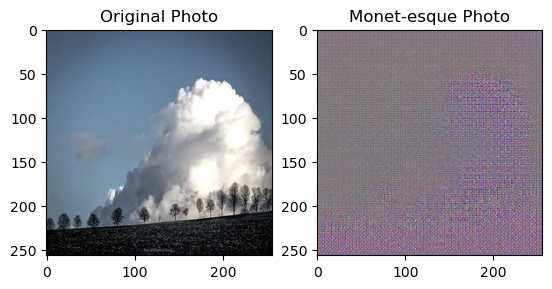

In [80]:
to_monet = monet_generator(batch_photo_images)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(batch_photo_images[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### CycleGAN model

By learning the mapping relationship between two different domains, CycleGAN can transform image styles without using paired training data.

We will inherit a tf.keras.Model to run fit () later to train our model. In the training step, the model converts the photo into a Monet painting and then back to the photo. The difference between the original photo and the photo that has been transformed twice is cyclic consistency loss.

In [81]:
# Setting up the new GAN model

class CycleGAN(Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10, **kwargs):
        super(CycleGAN, self).__init__(**kwargs)
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.d_loss_arr = []
        self.g_loss_arr = []

    def get_config(self):
        config = super().get_config()
        config.update({
            "lambda_cycle": self.lambda_cycle,
        })
        return config

    @classmethod
    def from_config(cls, config, custom_objects=None):
        # Create a new instance with the given configuration
        model_instance = cls(
            monet_generator=None,  # These will be set after loading weights
            photo_generator=None,
            monet_discriminator=None,
            photo_discriminator=None,
            lambda_cycle=config.get("lambda_cycle", 10)
        )
        
        return model_instance

    def save_weights_separately(self, base_path):
        # Save weights of each sub-model to separate files
        m_gen_weights_path = f"{base_path}_m_gen.weights.h5"
        p_gen_weights_path = f"{base_path}_p_gen.weights.h5"
        m_disc_weights_path = f"{base_path}_m_disc.weights.h5"
        p_disc_weights_path = f"{base_path}_p_disc.weights.h5"
        print('path',m_gen_weights_path)
        self.m_gen.save_weights(m_gen_weights_path)
        self.p_gen.save_weights(p_gen_weights_path)
        self.m_disc.save_weights(m_disc_weights_path)
        self.p_disc.save_weights(p_disc_weights_path)

    @classmethod
    def load_weights_separately(cls, base_path, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        # Load weights into each sub-model
        m_gen_weights_path = f"{base_path}_m_gen.weights.h5"
        p_gen_weights_path = f"{base_path}_p_gen.weights.h5"
        m_disc_weights_path = f"{base_path}_m_disc.weights.h5"
        p_disc_weights_path = f"{base_path}_p_disc.weights.h5"

        monet_generator.load_weights(m_gen_weights_path)
        photo_generator.load_weights(p_gen_weights_path)
        monet_discriminator.load_weights(m_disc_weights_path)
        photo_discriminator.load_weights(p_disc_weights_path)

        # Initialize and return the CycleGAN instance with loaded weights
        return cls(
            monet_generator=monet_generator,
            photo_generator=photo_generator,
            monet_discriminator=monet_discriminator,
            photo_discriminator=photo_discriminator,
            lambda_cycle=lambda_cycle
        )

      
    
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        # print(batch_data)
        real_monet, real_photo = batch_data
        # print("Real Monet shape:", real_monet.shape)
        # print("Real Photo shape:", real_photo.shape)
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Using discriminator to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        self.g_loss_arr.append(total_monet_gen_loss + total_photo_gen_loss)
        self.d_loss_arr.append(monet_disc_loss + photo_disc_loss)
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [82]:
with strategy.scope():
    def discriminator_loss(real, generated):
        #The output of the real image should be close to 1 ( considered real)
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        #The output of the generated image should be close to 0 ( considered fake)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        #The generator wants to produce images that the discriminator thinks are real ( the output is close to 1)
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    # LAMBDA-  The weight coefficient of the cyclic consistency loss, used to control the importance of this loss relative to other losses
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    def identity_loss(real_image, same_image, LAMBDA):
        return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))
    

In [83]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(5e-3, beta_1=0.7, 
    beta_2=0.999)
    photo_generator_optimizer = tf.keras.optimizers.Adam(5e-3, beta_1=0.7, 
    beta_2=0.999)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, 
    beta_2=0.999)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, 
    beta_2=0.999)

In [84]:
with strategy.scope():
    cycle_gan_model = CycleGAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

### Train model

In [85]:
with strategy.scope():
    if not LOAD_LOCALMODEL:
        history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)),
                            steps_per_epoch=(300//BATCH_SIZE),
                            epochs=EPOCHS,
                            verbose=2).history
        
        print('fit success')

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_history(history):
  
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # Helper function to compute the mean of each item in the list
    def compute_mean(loss_list):
        return [np.mean(item) if isinstance(item, (np.ndarray, tf.Tensor)) else item for item in loss_list]


    monet_gen_loss_avg = compute_mean(history['monet_gen_loss'])
    ax[0, 0].plot(monet_gen_loss_avg, label='Monet Generator Loss', marker='o')
    ax[0, 0].set_title('Monet Generator Loss Over Epochs')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].legend()
    ax[0, 0].grid(True)


    photo_gen_loss_avg = compute_mean(history['photo_gen_loss'])
    ax[0, 1].plot(photo_gen_loss_avg, label='Photo Generator Loss', marker='o')
    ax[0, 1].set_title('Photo Generator Loss Over Epochs')
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].set_ylabel('Loss')
    ax[0, 1].legend()
    ax[0, 1].grid(True)


    monet_disc_loss_avg = compute_mean(history['monet_disc_loss'])
    ax[1, 0].plot(monet_disc_loss_avg, label='Monet Discriminator Loss', marker='o')
    ax[1, 0].set_title('Monet Discriminator Loss Over Epochs')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    photo_disc_loss_avg = compute_mean(history['photo_disc_loss'])
    ax[1, 1].plot(photo_disc_loss_avg, label='Photo Discriminator Loss', marker='o')
    ax[1, 1].set_title('Photo Discriminator Loss Over Epochs')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].set_ylabel('Loss')
    ax[1, 1].legend()
    ax[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

if not LOAD_LOCALMODEL:
    plot_training_history(history)

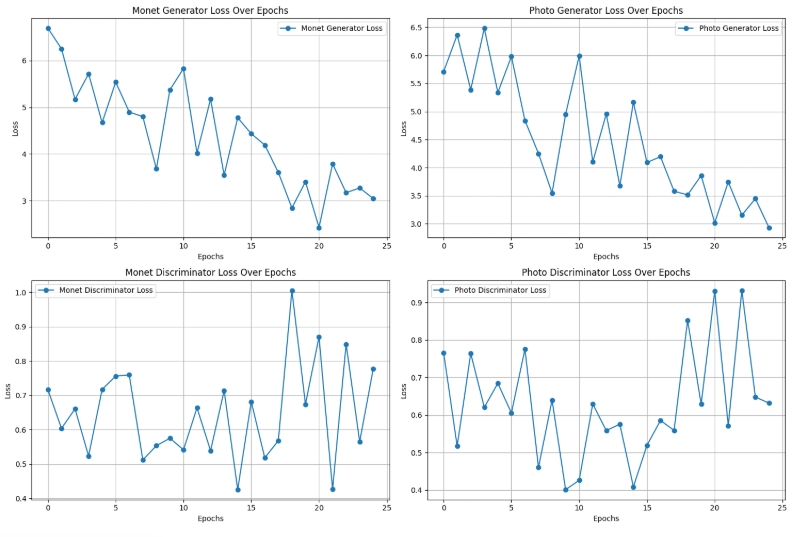

In [61]:
import shutil
import os

def create_folder(name,clearfile=False):
    path = OUT_PUT_PATH+name
    if(clearfile):
        print(path)
        if os.path.exists(path):
            shutil.rmtree(path)
            print(name,' Deletion complete')
        else:
            print(name,' Originally null')
            
    os.makedirs(name, exist_ok=True)

### Save Model weights 

In [62]:
if not LOAD_LOCALMODEL:
    create_folder('Model',False)

    with strategy.scope():
        cycle_gan_model.save_weights_separately( OUT_PUT_PATH+'Model/')

In [87]:
if  LOAD_LOCALMODEL:
    loaded_cycle_gan_model = CycleGAN.load_weights_separately(
        OUT_PUT_PATH+'Model/',
        monet_generator=monet_generator,
        photo_generator=photo_generator,
        monet_discriminator=monet_discriminator,
        photo_discriminator=photo_discriminator,
        lambda_cycle=10
    )

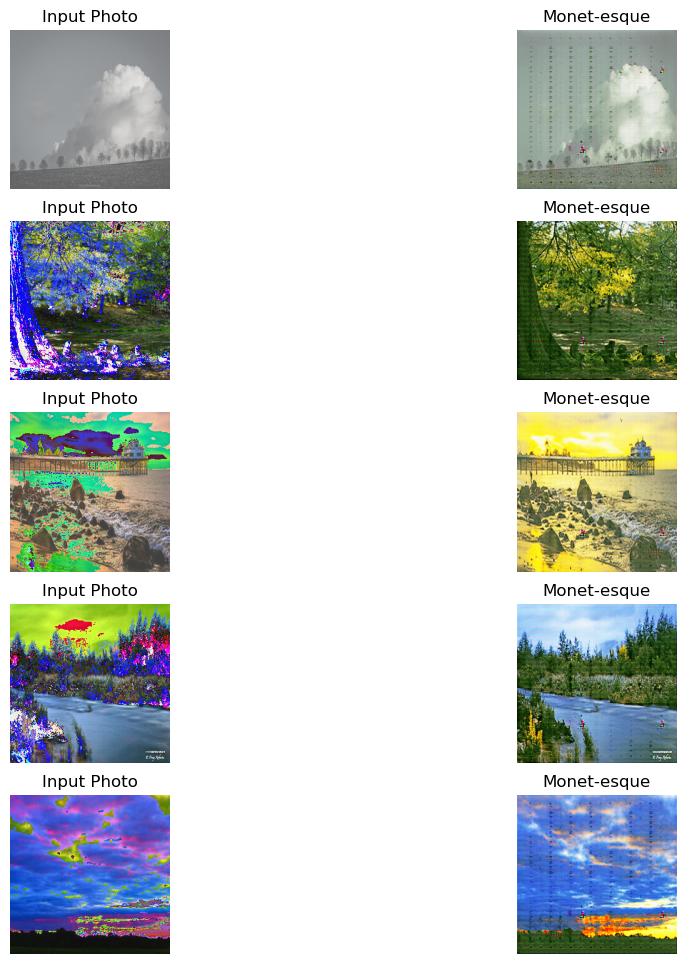

In [88]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_data.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [65]:
import os
from IPython.display import FileLink

if not LOAD_LOCALMODEL:
    os.chdir(OUT_PUT_PATH)
    folder_to_compress = 'Model'  
    output_tar_file = 'model_folder.tar.gz' 
   
    if not os.path.exists(folder_to_compress):
        print(f"Error: The folder '{folder_to_compress}' does not exist in the current directory.")
    else:
        !tar -czf {output_tar_file} {folder_to_compress}
        from IPython.display import FileLink
        display(FileLink(output_tar_file))

### Monet generator and Save images

In [ ]:
import PIL
create_folder('images',True)
i = 1
for img in photo_data:
    for batch in range(BATCH_SIZE):
        img_g=img[batch:batch+1]
        # print(img_g.shape)
        prediction = monet_generator(img_g, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save("images/" + str(i) + ".jpg")
        i += 1
        if i %100 ==0:
            print(i)
    if i >= 9000: 
        break


print('generator success')


In [ ]:
import zipfile
import os

def zip_directory(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

zip_directory('/kaggle/working/images', '/kaggle/working/images.zip')

In [ ]:
print('completion of task')

### Training and Conclusion

* EPOCHS =25 
* LR =2e-4 
* augment data : Nothing

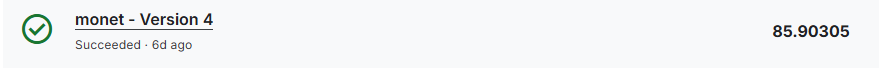


* EPOCHS =30
* LR =2e-4 
* augment data : Nothing 
  
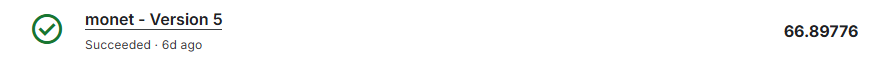

With the increase of epochs times, the model can recognize more features and train better

* EPOCHS =25
* LR =2e-4 
* augment data : repeat, shuffle, flip
  
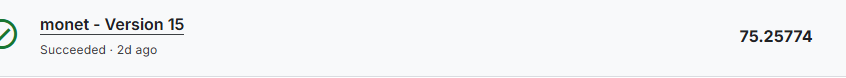

Augment data introduces more randomness, but the model learning gets worse

* EPOCHS =25
* LR =2e-4 
* augment data : Nothing

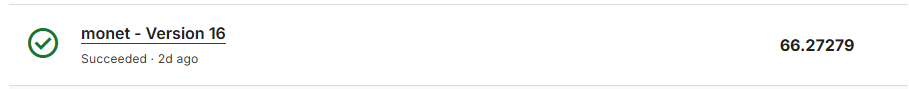

Cancel augment data, and we can find that the model performance is the same as before

* EPOCHS =25
* LR =2e-4 
* augment data : flip

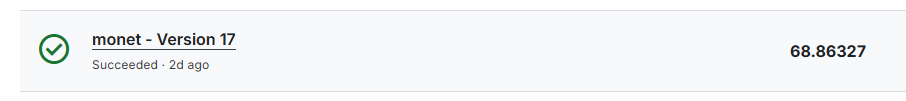

Flip only the image, it will not cause the model to deteriorate

* EPOCHS =25
* LR =2e-4 
* augment data : flip, Differentiable Augmentation (color\translation\cutout)

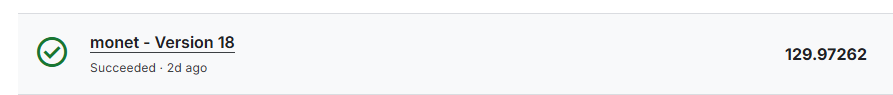

translation\cutout leads to too much loss of picture information and poor models

* EPOCHS =25
* LR =2e-4 
* augment data : flip, Differentiable Augmentation (color)
  
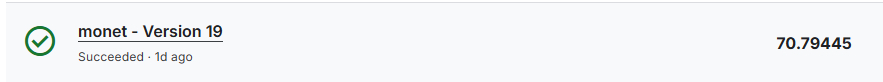

* EPOCHS =25
* LR =2e-3 
* augment data : flip, Differentiable Augmentation (color)

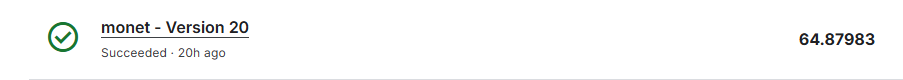


* EPOCHS =50
* LR =5e-3,beta_1=0.7
* augment data : flip, Differentiable Augmentation (color)
  
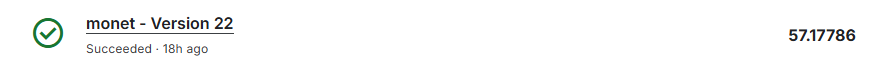


* EPOCHS =80
* LR =5e-3,beta_1=0.7
* augment data : flip, Differentiable Augmentation (color)
  
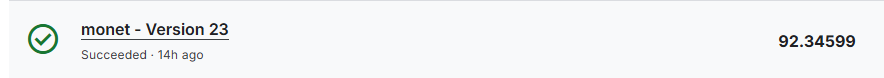

The model deteriorates after increasing EPOCHS, possibly because of overfitting